# 豆瓣电影短评分类 - 使用 LSTM

## 数据集

Dataset: https://www.kaggle.com/utmhikari/doubanmovieshortcomments，共包含212万条评论数据，这里只考虑两个分类，从1星和5星评论中各取10万条。本文的实现主要参考了 [Long Short-Term Memory](https://blog.floydhub.com/long-short-term-memory-from-zero-to-hero-with-pytorch/)。

# 如何使用 LSTM

关于 LSTM 的工作机制，可以查看[李沐的书](https://zh-v2.d2l.ai/chapter_recurrent-modern/lstm.html)。关于 LSTM 在 PyTorch 中的实现细节，可以查看其[官方文档](https://pytorch.org/docs/1.9.1/generated/torch.nn.LSTM.html)。这里尝试对使用 LSTM 处理文本做一个直观的理解。

## Tokenize

LSTM 适用于时间序列问题，文本是天然的时间序列。不过这个序列到底是什么并不那么显然。对于英语、法语这样的语言，可以考虑使用"词"，对于汉语，则可以考虑使用"字"或"词"。使用字或词是较为传统的方法，Bert、RoBERTa 等基于 Transformer 架构的模型则使用不同的 Subword 算法。上述这些方法做的事情，都属于 tokenizer，它将文本 tokenize 为一个 token 的序列。本文处理的是汉语的情形，使用最简单的"字"序列。

有了 token 序列，接下来需要将这些 token 转换为数值表示，最简单的处理方式是收集数据集中的所有 token，为每个 token 分配一个数值 id，这种方式本质上得到的是 one-hot 编码。

## Embedding 层

one-hot 编码是极其稀疏的，而且 token 的表示与其语义毫无关联，因此通常处理方法是将 one-hot 转换为 word embedding，这正是 `torch.nnEmbedding` 做的事情。

In [1]:
import torch
import torch.nn as nn

vocab_size = 100
embedding_dim = 5

embedding = nn.Embedding(vocab_size, embedding_dim)
# embedding 是一个 lookup table，它将 `vocab_size` 个 token 分别表示为 `embedding_dim` 大小的向量
print(f'embedding lookup table:', embedding.weight.data.shape)

# 如果一句话由三个 token 构成，其 id 分别是 [2, 1, 3]
sent_token_ids = [2, 1, 3]
embedded = embedding(torch.LongTensor(sent_token_ids))

# 这句话被表示为 (3, 5) 大小的矩阵
embedded.data

embedding lookup table: torch.Size([100, 5])


tensor([[-0.2362, -0.7930, -0.3985,  0.2873,  0.9603],
        [ 1.8757,  0.9257, -0.9709, -0.3830, -0.3318],
        [ 1.4579,  2.0634, -0.2326, -0.7954,  0.0490]])

这样，一个文本序列表示为了矩阵，但每个文本长短不一，因此需要统一其长度，过长的截断，过短的则要填充。到这里就得到了可以输入到 LSTM 层的数据。

## LSTM 层

通过下面的代码来查看 LSTM 输入和输出的情况。

In [2]:
# 每次输入的形状：(batch_size, seq_len, embedding_dim)
# 即 `batch_size` 个文本，每个文本长度 `seq_len`，每个 token 表示为 `embedding_dim` 大小的向量
batch_size = 3
seq_len = 10
embedding_dim = 5

# LSTM 的参数
n_layers = 2
hidden_dim = 6
lstm_layer = nn.LSTM(num_layers=n_layers,
                     input_size=embedding_dim,
                     hidden_size=hidden_dim,
                     batch_first=True)

# 这里测试一下输入和输出的样子
inputs = torch.randn(batch_size, seq_len, embedding_dim)
print(f'input shape: {inputs.shape}')

hidden_state = torch.randn(n_layers, batch_size, hidden_dim)
cell_state = torch.randn(n_layers, batch_size, hidden_dim)
hidden = (hidden_state, cell_state)

last_layer_outs, (last_hidden_states, last_cell_states) = lstm_layer(inputs, hidden)
print(f'last_layer_outputs shape: ', last_layer_outs.shape)
print(f'last_hidden_states shape: ', last_hidden_states.shape)
print(f'last_cell_states shape: ', last_cell_states.shape)

input shape: torch.Size([3, 10, 5])
last_layer_outputs shape:  torch.Size([3, 10, 6])
last_hidden_states shape:  torch.Size([2, 3, 6])
last_cell_states shape:  torch.Size([2, 3, 6])


## 分类任务

也就是说，LSTM 层的输出是各种隐藏状态，接下来需要通过这些隐藏状态实现分类。下面使用的是 LSTM 层返回值的第一部分，即最后一层的所有隐藏状态，将其连接到一个 `nn.Linear` 层，再辅以 `nn.Sigmoid`，因为这里要实现的是二分类。

至此对数据在整个流程中的变化有所了解了，下面是具体的实现。

# 代码实现

## 加载数据

In [3]:
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('douban_movie_comments.csv', usecols=['Comment', 'Star'])
len(df), df.Star.value_counts()

(200000,
 1    100000
 5    100000
 Name: Star, dtype: int64)

In [5]:
def preprocess_text(text):
    return text.strip().lower()

comments = [preprocess_text(c) for c in df.Comment]
labels = [1 if star == 5 else 0 for star in df.Star]

len(comments), len(labels)

(200000, 200000)

In [6]:
from sklearn.model_selection import train_test_split

train_comments, val_test_comments, train_labels, val_test_labels = train_test_split(comments, labels, test_size=0.3, shuffle=False)
val_comments, test_comments, val_labels, test_labels = train_test_split(val_test_comments,
                                                                        val_test_labels,
                                                                        test_size=0.5,
                                                                        shuffle=False)

len(train_comments), len(val_comments), len(test_comments), len(val_labels)

(140000, 30000, 30000, 30000)

## 构建词汇表

In [7]:
from typing import List

PADDING = '[PAD]'
UNKNOWN = '[UNK]'


def build_vocab(texts: List[str], tokenizer, min_token_freq=1):
    c_tokens = Counter()
    for text in texts:
        for token in tokenizer(text):
            c_tokens[token] += 1

    if min_token_freq > 1:
        c_tokens = Counter({k: v for k, v in c_tokens.items() if v >= MIN_FREQ})

    vocab = [PADDING, UNKNOWN] + [w for w, _ in c_tokens.most_common()]
    word2idx = {w: i for i, w in enumerate(vocab)}
    idx2word = {i: w for w, i in word2idx.items()}
    return word2idx, idx2word

In [8]:
MIN_FREQ = 2
tokenizer=lambda text: list(text)

word2idx, idx2word = build_vocab(train_comments,
                                 tokenizer=tokenizer,
                                 min_token_freq=MIN_FREQ)

len(word2idx), len(idx2word)

(5313, 5313)

## 文本长度统计

In [9]:
text_lengths = [len(s) for s in train_comments]
print('最大句子长度：{}, 最小句子长度：{}, 平均句子长度：{:.2f}, 句子长度中位数：{:.2f}'.format(
    max(text_lengths), min(text_lengths), np.mean(text_lengths), np.median(text_lengths)))

df_len = pd.DataFrame({'text_len': text_lengths})
print(df_len.describe())

最大句子长度：196, 最小句子长度：1, 平均句子长度：33.95, 句子长度中位数：20.00
            text_len
count  140000.000000
mean       33.946979
std        35.106944
min         1.000000
25%        10.000000
50%        20.000000
75%        45.000000
max       196.000000


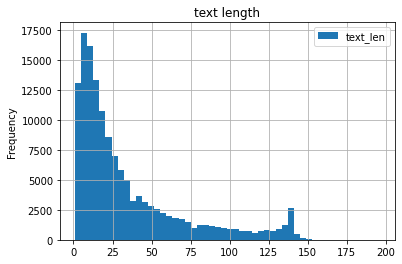

In [10]:
df_len.plot.hist('text_len',  grid=True, title='text length', bins=50);

绝大多数句子程度都在 100 以下，因此序列长度设置为 100。

## 文本的向量化

In [11]:
def text_to_vec(sent: str):
    sent_word_ids = []
    for word in tokenizer(sent):
        sent_word_ids.append(word2idx.get(word) or word2idx[UNKNOWN])
    return sent_word_ids

train_vectors = [text_to_vec(sent) for sent in train_comments]
val_vectors = [text_to_vec(sent) for sent in val_comments]
test_vectors = [text_to_vec(sent) for sent in test_comments]

# every sentence is a [word_id]
train_vectors[0]

[853,
 123,
 39,
 1189,
 185,
 41,
 617,
 514,
 424,
 173,
 774,
 1043,
 2,
 27,
 13,
 39,
 23,
 44,
 94,
 8,
 29,
 147,
 64,
 12,
 94,
 170,
 29,
 2,
 52,
 20,
 47,
 84,
 26,
 94,
 238,
 29,
 170,
 29,
 12,
 21,
 94,
 8,
 29,
 7,
 4]

In [12]:
# pad texts
def pad_input(sent_vecs, seq_len):
    features = np.full((len(sent_vecs), seq_len), fill_value=word2idx[PADDING], dtype=int)
    for i, sent_vec in enumerate(sent_vecs):
        if len(sent_vec) != 0:
            features[i, -len(sent_vec):] = np.array(sent_vec)[:seq_len]
    return features


seq_len = 100
train_vectors = pad_input(train_vectors, seq_len)
val_vectors = pad_input(val_vectors, seq_len)
test_vectors = pad_input(test_vectors, seq_len)

train_vectors[0].shape, train_vectors[0]

((100,),
 array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
         853,  123,   39, 1189,  185,   41,  617,  514,  424,  173,  774,
        1043,    2,   27,   13,   39,   23,   44,   94,    8,   29,  147,
          64,   12,   94,  170,   29,    2,   52,   20,   47,   84,   26,
          94,  238,   29,  170,   29,   12,   21,   94,    8,   29,    7,
           4]))

In [13]:
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)
test_labels = np.array(test_labels)

len(train_labels), len(val_labels), len(test_labels)

(140000, 30000, 30000)

## 准备模型

In [14]:
import torch
import torch.nn as nn

from torch.utils.data import TensorDataset, DataLoader

In [15]:
batch_size = 256

train_data = TensorDataset(torch.from_numpy(train_vectors), torch.from_numpy(train_labels))
val_data = TensorDataset(torch.from_numpy(val_vectors), torch.from_numpy(val_labels))
test_data = TensorDataset(torch.from_numpy(test_vectors), torch.from_numpy(test_labels))

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last=True)

In [16]:
# check GPUs
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device

device(type='cpu')

In [17]:
# define layer
class SentimentNet(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        super(SentimentNet, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(num_layers=n_layers, input_size=embedding_dim, hidden_size=hidden_dim,
                            dropout=drop_prob,
                            batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, hidden):
        #print(f'x size: {x.shape}')
        batch_size = x.size(0)
        x = x.long()
        embeds = self.embedding(x)

        # lstm_out shape: (batch_size, seq_len, hidden_size)
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

        out = self.dropout(lstm_out)
        # out shape -> (batch_size * seq_len, 1)
        out = self.fc(out)
        out = self.sigmoid(out)

        # out shape -> (batch_size, seq_len)
        out = out.view(batch_size, -1)
        # out shape -> (batch_size,)
        out = out[:, -1]
        return out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [18]:
vocab_size = len(word2idx)
output_size = 1
embedding_dim = 50
hidden_dim = 32
n_layers = 2

model = SentimentNet(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
model.to(device)

lr = 0.01
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

model

SentimentNet(
  (embedding): Embedding(5313, 50)
  (lstm): LSTM(50, 32, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

## 训练模型

In [19]:
import time

epochs = 3
counter = 0
print_every = 100
clip = 5
valid_loss_min = np.Inf

start = time.time()
model.train()
for i in range(epochs):
    h = model.init_hidden(batch_size)

    for inputs, labels in train_loader:
        counter += 1
        h = tuple([e.data for e in h])
        inputs, labels = inputs.to(device), labels.to(device)
        model.zero_grad()
        output, h = model(inputs, h)
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        if counter % print_every == 0:
            val_h = model.init_hidden(batch_size)
            val_losses = []
            model.eval()
            for inp, lab in val_loader:
                val_h = tuple([each.data for each in val_h])
                inp, lab = inp.to(device), lab.to(device)
                out, val_h = model(inp, val_h)
                val_loss = criterion(out.squeeze(), lab.float())
                val_losses.append(val_loss.item())

            model.train()
            print("Epoch: {}/{}...".format(i+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)),
                  "Time elapsed: {:.3f}".format(time.time() - start))
            if np.mean(val_losses) <= valid_loss_min:
                torch.save(model.state_dict(), './state_dict.pt')
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
                valid_loss_min = np.mean(val_losses)

Epoch: 1/3... Step: 100... Loss: 0.405695... Val Loss: 0.400934 Time elapsed: 23.160
Validation loss decreased (inf --> 0.400934).  Saving model ...
Epoch: 1/3... Step: 200... Loss: 0.408278... Val Loss: 0.351721 Time elapsed: 46.190
Validation loss decreased (0.400934 --> 0.351721).  Saving model ...
Epoch: 1/3... Step: 300... Loss: 0.419433... Val Loss: 0.315268 Time elapsed: 69.263
Validation loss decreased (0.351721 --> 0.315268).  Saving model ...
Epoch: 1/3... Step: 400... Loss: 0.339693... Val Loss: 0.294527 Time elapsed: 92.483
Validation loss decreased (0.315268 --> 0.294527).  Saving model ...
Epoch: 1/3... Step: 500... Loss: 0.255131... Val Loss: 0.284580 Time elapsed: 115.489
Validation loss decreased (0.294527 --> 0.284580).  Saving model ...
Epoch: 2/3... Step: 600... Loss: 0.340236... Val Loss: 0.281590 Time elapsed: 138.568
Validation loss decreased (0.284580 --> 0.281590).  Saving model ...
Epoch: 2/3... Step: 700... Loss: 0.294741... Val Loss: 0.290420 Time elapsed: 1

## 模型加载

In [20]:
# Loading the best model
model.load_state_dict(torch.load('./state_dict.pt'))

test_losses = []
num_correct = 0
h = model.init_hidden(batch_size)

model.eval()
for inputs, labels in test_loader:
    h = tuple([each.data for each in h])
    inputs, labels = inputs.to(device), labels.to(device)
    output, h = model(inputs, h)
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    pred = torch.round(output.squeeze())  # Rounds the output to 0/1
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)

print("Test loss: {:.3f}".format(np.mean(test_losses)))
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}%".format(test_acc * 100))

Test loss: 0.254
Test accuracy: 89.533%


## 预测

In [21]:
def predict_labels(sents: List[str]):
    test_sent_words = [tokenizer(sent) for sent in sents]
    test_vecs = [[word2idx.get(w) or word2idx.get(UNKNOWN) for w in words] for words in test_sent_words]
    test_vecs = pad_input(test_vecs, seq_len)

    model.eval()

    test_h = model.init_hidden(len(test_sents))
    test_output, test_h = model(torch.from_numpy(test_vecs), test_h)
    test_pred = torch.round(test_output.squeeze())

    predicted = []
    for pred, prob in zip(test_pred, test_output.squeeze()):
        predicted.append({'label': pred.item(), 'prob': prob.item()})
    return predicted

In [22]:
test_sents = ['史上最烂的电影，没有之一',
              '我最喜欢的电影，太棒了',
              '不打一星对不起我的电影票钱',
              '无语',
              '无力吐槽',
              '不是我喜欢的类型',
              '要推荐给所有朋友',
              '不会推荐给任何朋友',
              '居然看哭了！',
              '我想我以后不会再看这个导演的作品了']

predicted = predict_labels(test_sents)
for pred, sent in zip(predicted, test_sents):
    print(int(pred['label']), f'{pred["prob"]:.3f}', sent)

0 0.005 史上最烂的电影，没有之一
1 0.997 我最喜欢的电影，太棒了
0 0.012 不打一星对不起我的电影票钱
0 0.008 无语
0 0.010 无力吐槽
0 0.231 不是我喜欢的类型
1 0.968 要推荐给所有朋友
0 0.229 不会推荐给任何朋友
1 0.935 居然看哭了！
0 0.039 我想我以后不会再看这个导演的作品了
